# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import statsmodels.api as sm
import glob

from datetime import timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows    = None
    #pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])
#criando pasta imagens
if not os.path.exists("imagens"):
    os.mkdir("imagens")
#Redefinindo as sementes aleatórias 
def reset_random_seeds():
    random.seed(42)
    np.random.seed(42)

jupyter_settings()

## 0.2 Carregando dados

In [3]:
folders = ["41", "42", "44"]
for fld in folders:
    folder = "datasets/campinas/" + fld
    out_folder = "datasets/campinas/" + fld + ".1"
    for count, filename in enumerate(os.listdir(folder)):
        read_file = pd.read_excel(os.path.join(folder, filename))
        read_file.to_csv(os.path.join(out_folder, '054B7020C0200' + fld + '_' + str(count) + '.csv'), index=None, header=True)


In [8]:
def process_files(path):
    # Obtém uma lista de todos os arquivos CSV
    all_files = glob.glob(path + "/*.csv")

    # Cria uma lista para armazenar os DataFrames
    df_list = []

    # Lê cada arquivo CSV e adiciona à lista df_list
    for filename in all_files:
        df = pd.read_csv(filename, skiprows=7)
        df['Time'] = df['Time'].str.split("(", n = 1, expand = True)[0].str.strip()
        df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M:%S')
        df_list.append(df)

    # Concatena todos os DataFrames na lista df_list
    df_raw = pd.concat(df_list, axis=0, ignore_index=True)

    # # Encontra e exclui linhas duplicadas com base na coluna 'Time'
    # duplicadas = df_raw.duplicated(subset='Time', keep=False)
    # if duplicadas.any():
    #     print("Linhas duplicadas encontradas:")
    #     print(df_raw[duplicadas])
    # df_raw = df_raw[~duplicadas]

    # Ordena o DataFrame por 'Time'
    df_raw.sort_values('Time', inplace=True)

    # Adiciona uma coluna de contagem
    df_raw['Count'] = np.arange(len(df_raw))

    # Retorna o DataFrame resultante
    return df_raw


# # Processa os arquivos no diretório 'datasets/campinas/42.1'
# df_42_raw = process_files('datasets/campinas/42.1')

# # Processa os arquivos no diretório 'datasets/campinas/41.1'
# df_41_raw = process_files('datasets/campinas/41.1')

# # Processa os arquivos no diretório 'datasets/campinas/44.1'
# df_44_raw = process_files('datasets/campinas/44.1')

# Antes de salvar os novos arquivos, verifique se há arquivos antigos e exclua-os
for df, path in [(df_42_raw, 'datasets/campinas/42.1'), (df_41_raw, 'datasets/campinas/41.1'), (df_44_raw, 'datasets/campinas/44.1')]:
    if os.path.exists(path + '.csv'):
        os.remove(path + '.csv')
    df.to_csv(path + '.csv')


In [5]:
# #Salva os DataFrames em arquivos CSV
# df_42_raw.to_csv('datasets/campinas/42.1_processed.csv', index=False)
# df_41_raw.to_csv('datasets/campinas/41.1_processed.csv', index=False)
# df_44_raw.to_csv('datasets/campinas/44.1_processed.csv', index=False)

In [9]:
df_42_raw.head()

,Number,Time,Working State,Alarm Code,DC Voltage PvPV1(V),DC Current PvPV1(A),DC Power PvPV1(W),DC Voltage PvPV2(V),DC Current PvPV2(A),DC Power PvPV2(W),...,Total Yield(kWh),IGBT Temperature(℃),Inverter Ambient Temperature(℃),Dispersion Rate,Initialize the grounding voltage(V),DC bus voltage(V),Dc bus half voltage(V),Insulation Resistance Realtime Value,Count,Date
0,1,2021-09-23 10:25:53,Normal,,406.1,0.1,41,404.9,0.1,40,...,2.0,24.4,,0.0,0.0,0.0,0.0,,0,2021-09-23
1,2,2021-09-23 10:30:53,Normal,,317.4,8.1,2571,324.2,8.0,2594,...,2.0,31.1,,0.0,0.0,0.0,0.0,,1,2021-09-23
2,3,2021-09-23 10:35:54,Normal,,322.6,8.0,2581,321.7,8.1,2606,...,3.0,40.4,,0.0,0.0,0.0,0.0,,2,2021-09-23
3,4,2021-09-23 10:40:59,Normal,,321.1,8.0,2569,320.3,8.1,2594,...,4.0,46.4,,0.0,0.0,0.0,0.0,,3,2021-09-23
4,5,2021-09-23 10:46:00,Normal,,328.3,8.0,2626,327.2,8.1,2650,...,4.0,51.0,,0.0,0.0,0.0,0.0,,4,2021-09-23


# 1.0 DATA DESCRIPTION

In [10]:
columns = ['Count','Time', 'Total Inverter Power(W)', 'AC Voltage U(V)', 'AC Current U(A)', 'Today Yield(kWh)', 'Total Yield(kWh)', 'IGBT  Temperature(℃)']

# Verifica se todas as colunas existem em df_41_raw
if all(item in df_41_raw.columns for item in columns):
    df_41 = df_41_raw[columns].copy()
    df_41.rename(columns = {'Time':'time', 'Count':'contatdor','Total Inverter Power(W)':'DC_power', 'AC Voltage U(V)':'tensão_AC', 'AC Current U(A)':'corrente_AC', 'Today Yield(kWh)':'acumulado_diário', 'Total Yield(kWh)':'Acumulado_total', 'IGBT  Temperature(℃)':'temperatura_IGBT'}, inplace = True)
else:
    print("Algumas colunas não foram encontradas em df_41_raw.")

# Verifica se todas as colunas existem em df_42_raw
if all(item in df_42_raw.columns for item in columns):
    df_42 = df_42_raw[columns].copy()
    df_42.rename(columns = {'Time':'time', 'Count':'contatdor','Total Inverter Power(W)':'DC_power', 'AC Voltage U(V)':'tensão_AC', 'AC Current U(A)':'corrente_AC', 'Today Yield(kWh)':'acumulado_diário', 'Total Yield(kWh)':'Acumulado_total', 'IGBT  Temperature(℃)':'temperatura_IGBT'}, inplace = True)
else:
    print("Algumas colunas não foram encontradas em df_42_raw.")

# Verifica se todas as colunas existem em df_44_raw
if all(item in df_44_raw.columns for item in columns):
    df_44 = df_44_raw[columns].copy()
    df_44.rename(columns = {'Time':'time', 'Count':'contatdor','Total Inverter Power(W)':'DC_power', 'AC Voltage U(V)':'tensão_AC', 'AC Current U(A)':'corrente_AC', 'Today Yield(kWh)':'acumulado_diário', 'Total Yield(kWh)':'Acumulado_total', 'IGBT  Temperature(℃)':'temperatura_IGBT'}, inplace = True)
else:
    print("Algumas colunas não foram encontradas em df_44_raw.")


Algumas colunas não foram encontradas em df_41_raw.
Algumas colunas não foram encontradas em df_42_raw.
Algumas colunas não foram encontradas em df_44_raw.


## 1.2 Data dimension

In [17]:
print('41 rows:{}'.format(df_41_raw.shape[0]))
print('41 columns:{}'.format(df_41_raw.shape[1]))
print('42 rows:{}'.format(df_42_raw.shape[0]))
print('42 columns:{}'.format(df_42_raw.shape[1]))
print('44 rows:{}'.format(df_44_raw.shape[0]))
print('44 columns:{}'.format(df_44_raw.shape[1]))

41 rows:56927
41 columns:32
42 rows:57302
42 columns:32
44 rows:58670
44 columns:32


## 1.3 Data Types

In [20]:
df_41_raw.dtypes

Number                                           int64
Time                                    datetime64[ns]
Working State                                   object
Alarm Code                                      object
DC Voltage PvPV1(V)                            float64
DC Current PvPV1(A)                            float64
DC Power PvPV1(W)                                int64
DC Voltage PvPV2(V)                            float64
DC Current PvPV2(A)                            float64
DC Power PvPV2(W)                                int64
DC Voltage PvPV3(V)                            float64
DC Current PvPV3(A)                            float64
DC Power PvPV3(W)                                int64
DC Voltage PvPV4(V)                            float64
DC Current PvPV4(A)                            float64
DC Power PvPV4(W)                                int64
AC Voltage U(V)                                float64
AC Current U(A)                                float64
Total Inve

In [21]:
df_42_raw.dtypes

Number                                           int64
Time                                    datetime64[ns]
Working State                                   object
Alarm Code                                      object
DC Voltage PvPV1(V)                            float64
DC Current PvPV1(A)                            float64
DC Power PvPV1(W)                                int64
DC Voltage PvPV2(V)                            float64
DC Current PvPV2(A)                            float64
DC Power PvPV2(W)                                int64
DC Voltage PvPV3(V)                            float64
DC Current PvPV3(A)                            float64
DC Power PvPV3(W)                                int64
DC Voltage PvPV4(V)                            float64
DC Current PvPV4(A)                            float64
DC Power PvPV4(W)                                int64
AC Voltage U(V)                                float64
AC Current U(A)                                float64
Total Inve

In [22]:
df_44_raw.dtypes

Number                                           int64
Time                                    datetime64[ns]
Working State                                   object
Alarm Code                                      object
DC Voltage PvPV1(V)                            float64
DC Current PvPV1(A)                            float64
DC Power PvPV1(W)                                int64
DC Voltage PvPV2(V)                            float64
DC Current PvPV2(A)                            float64
DC Power PvPV2(W)                                int64
DC Voltage PvPV3(V)                            float64
DC Current PvPV3(A)                            float64
DC Power PvPV3(W)                                int64
DC Voltage PvPV4(V)                            float64
DC Current PvPV4(A)                            float64
DC Power PvPV4(W)                                int64
AC Voltage U(V)                                float64
AC Current U(A)                                float64
Total Inve

## 1.4 Check NA

In [19]:
df_41_raw.isna().sum()

Number                                  0
Time                                    0
Working State                           0
Alarm Code                              0
DC Voltage PvPV1(V)                     0
DC Current PvPV1(A)                     0
DC Power PvPV1(W)                       0
DC Voltage PvPV2(V)                     0
DC Current PvPV2(A)                     0
DC Power PvPV2(W)                       0
DC Voltage PvPV3(V)                     0
DC Current PvPV3(A)                     0
DC Power PvPV3(W)                       0
DC Voltage PvPV4(V)                     0
DC Current PvPV4(A)                     0
DC Power PvPV4(W)                       0
AC Voltage U(V)                         0
AC Current U(A)                         0
Total Inverter Power(W)                 0
AC Frequency(Hz)                        0
Today Yield(kWh)                        0
Month Yield(kWh)                        0
Annual Yield(kWh)                       0
Total Yield(kWh)                  

In [23]:
df_42_raw.isna().sum()

Number                                  0
Time                                    0
Working State                           0
Alarm Code                              0
DC Voltage PvPV1(V)                     0
DC Current PvPV1(A)                     0
DC Power PvPV1(W)                       0
DC Voltage PvPV2(V)                     0
DC Current PvPV2(A)                     0
DC Power PvPV2(W)                       0
DC Voltage PvPV3(V)                     0
DC Current PvPV3(A)                     0
DC Power PvPV3(W)                       0
DC Voltage PvPV4(V)                     0
DC Current PvPV4(A)                     0
DC Power PvPV4(W)                       0
AC Voltage U(V)                         0
AC Current U(A)                         0
Total Inverter Power(W)                 0
AC Frequency(Hz)                        0
Today Yield(kWh)                        0
Month Yield(kWh)                        0
Annual Yield(kWh)                       0
Total Yield(kWh)                  

In [25]:
df_44_raw.isna().sum()

Number                                  0
Time                                    0
Working State                           0
Alarm Code                              0
DC Voltage PvPV1(V)                     0
DC Current PvPV1(A)                     0
DC Power PvPV1(W)                       0
DC Voltage PvPV2(V)                     0
DC Current PvPV2(A)                     0
DC Power PvPV2(W)                       0
DC Voltage PvPV3(V)                     0
DC Current PvPV3(A)                     0
DC Power PvPV3(W)                       0
DC Voltage PvPV4(V)                     0
DC Current PvPV4(A)                     0
DC Power PvPV4(W)                       0
AC Voltage U(V)                         0
AC Current U(A)                         0
Total Inverter Power(W)                 0
AC Frequency(Hz)                        0
Today Yield(kWh)                        0
Month Yield(kWh)                        0
Annual Yield(kWh)                       0
Total Yield(kWh)                  

## 1.5 Fillout NA/ Drop duplicates

In [ ]:
df_41 = df_41.drop_duplicates()
df_42 = df_42.drop_duplicates()
df_44 = df_44.drop_duplicates()

In [ ]:
print('41 rows:{}'.format(df_41.shape[0]))
print('42 rows:{}'.format(df_42.shape[0]))
print('44 rows:{}'.format(df_44.shape[0]))

41 rows:21417
42 rows:21038
44 rows:21197


## 1.6 Change Types

In [ ]:
df_41['time'] = pd.to_datetime(df_41['time'])
df_42['time'] = pd.to_datetime(df_42['time'])
df_44['time'] = pd.to_datetime(df_44['time'])

## 1.7 Statistical Description

### 1.7.1 Numerical Attributes

In [ ]:
def Statistics(df):
    num_attributes = df.select_dtypes(include = ['int64', 'float64'])
    
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T # transform to dataframe to facilitate visualization
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T # skewness
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [ ]:
Statistics(df_41)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10497.0,10497.0,3237.101275,2651.0,2681.760147,0.539482,-0.899878
1,ac_out_w,0.0,10020.0,10020.0,3116.453752,2560.0,2614.439969,0.528769,-0.925972
2,daily_kwh,0.0,61.8,61.8,22.058552,21.3,17.044208,0.286180,-1.106668
3,total_kwh,15530.0,21055.0,5525.0,18370.001914,18338.0,1553.756788,-0.035001,-1.152128
4,inverter_celsius,22.5,73.6,51.1,46.913896,45.7,11.990310,0.189535,-1.142630


In [ ]:
Statistics(df_42)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10598.0,10598.0,3469.686187,2829.0,2886.697553,0.545352,-0.905959
1,ac_out_w,0.0,10170.0,10170.0,3357.560605,2760.0,2812.043298,0.526951,-0.935640
2,daily_kwh,0.0,66.5,66.5,23.738102,22.9,18.356936,0.288563,-1.106089
3,total_kwh,16764.0,22720.0,5956.0,19825.518680,19788.5,1673.500967,-0.031595,-1.152076
4,inverter_celsius,21.8,76.1,54.3,47.312321,46.2,12.616930,0.181772,-1.152462


In [ ]:
Statistics(df_44)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10485.0,10485.0,3462.771005,2824.0,2890.536851,0.547731,-0.905293
1,ac_out_w,0.0,10200.0,10200.0,3381.492192,2790.0,2831.411477,0.527712,-0.936218
2,daily_kwh,0.0,66.5,66.5,23.905567,23.1,18.464993,0.285818,-1.109533
3,total_kwh,16841.0,22836.0,5995.0,19922.485305,19887.0,1685.226243,-0.033956,-1.151814
4,inverter_celsius,21.2,75.9,54.7,46.984276,45.9,12.722135,0.191006,-1.139539


### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes = df_41.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]']) 
# cat_attributes

# 2.0 FEATURE ENGINEERING

In [ ]:
df_41['year'] = df_41['time'].dt.year
df_41['month'] = df_41['time'].dt.month
df_41['week_of_year'] = df_41['time'].dt.weekofyear
df_41['day_of_week'] = df_41['time'].dt.dayofweek.apply(lambda x: x + 1)
df_41['day'] = df_41['time'].dt.day
df_41['hour'] = df_41['time'].dt.hour
df_41['minute'] = df_41['time'].dt.minute

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

In [ ]:
df_42['year'] = df_42['time'].dt.year
df_42['month'] = df_42['time'].dt.month
df_42['week_of_year'] = df_42['time'].dt.weekofyear
df_42['day_of_week'] = df_42['time'].dt.dayofweek.apply(lambda x: x + 1)
df_42['day'] = df_42['time'].dt.day
df_42['hour'] = df_42['time'].dt.hour
df_42['minute'] = df_42['time'].dt.minute

In [ ]:
df_44['year'] = df_44['time'].dt.year
df_44['month'] = df_44['time'].dt.month
df_44['week_of_year'] = df_44['time'].dt.weekofyear
df_44['day_of_week'] = df_44['time'].dt.dayofweek.apply(lambda x: x + 1)
df_44['day'] = df_44['time'].dt.day
df_44['hour'] = df_44['time'].dt.hour
df_44['minute'] = df_44['time'].dt.minute

# 3.0 FILTERING OF VARIABLES

# 4.0 EXPLORATORY DATA ANALYSIS

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

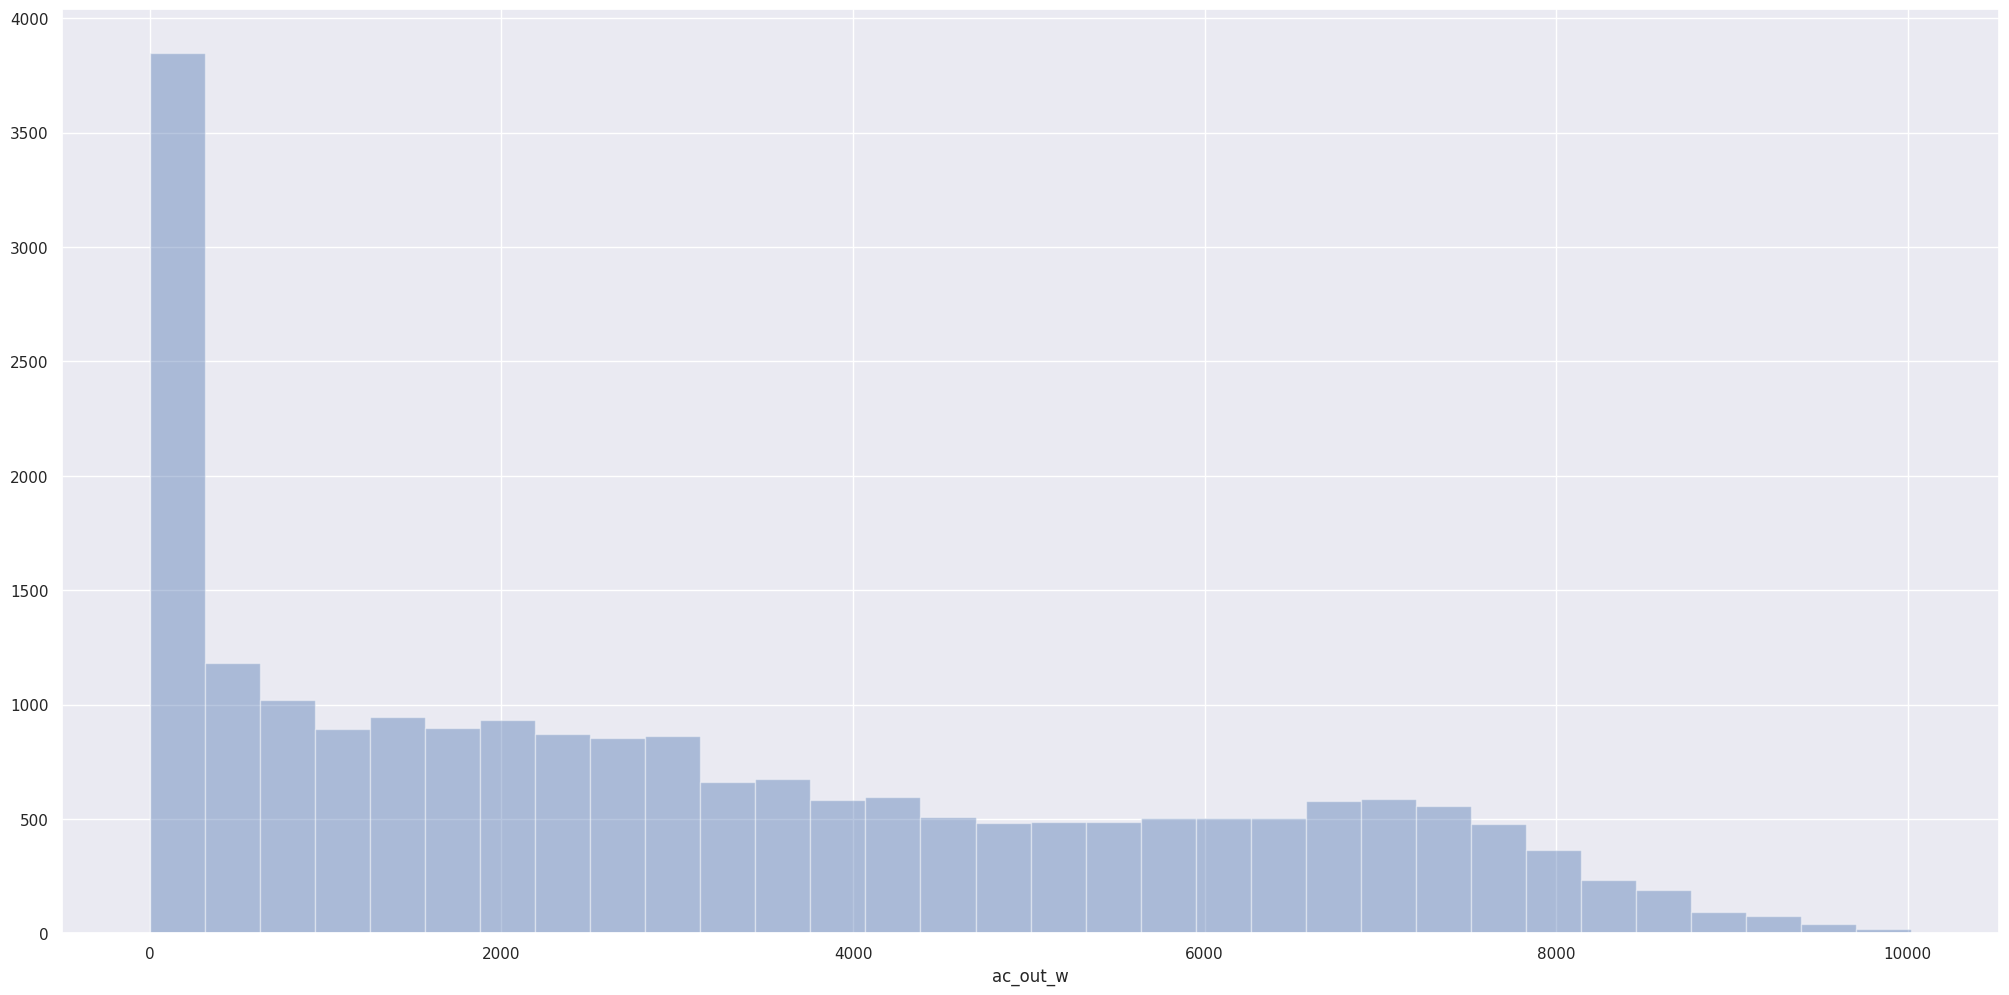

In [ ]:
sns.distplot(df_41['ac_out_w'], kde=False);

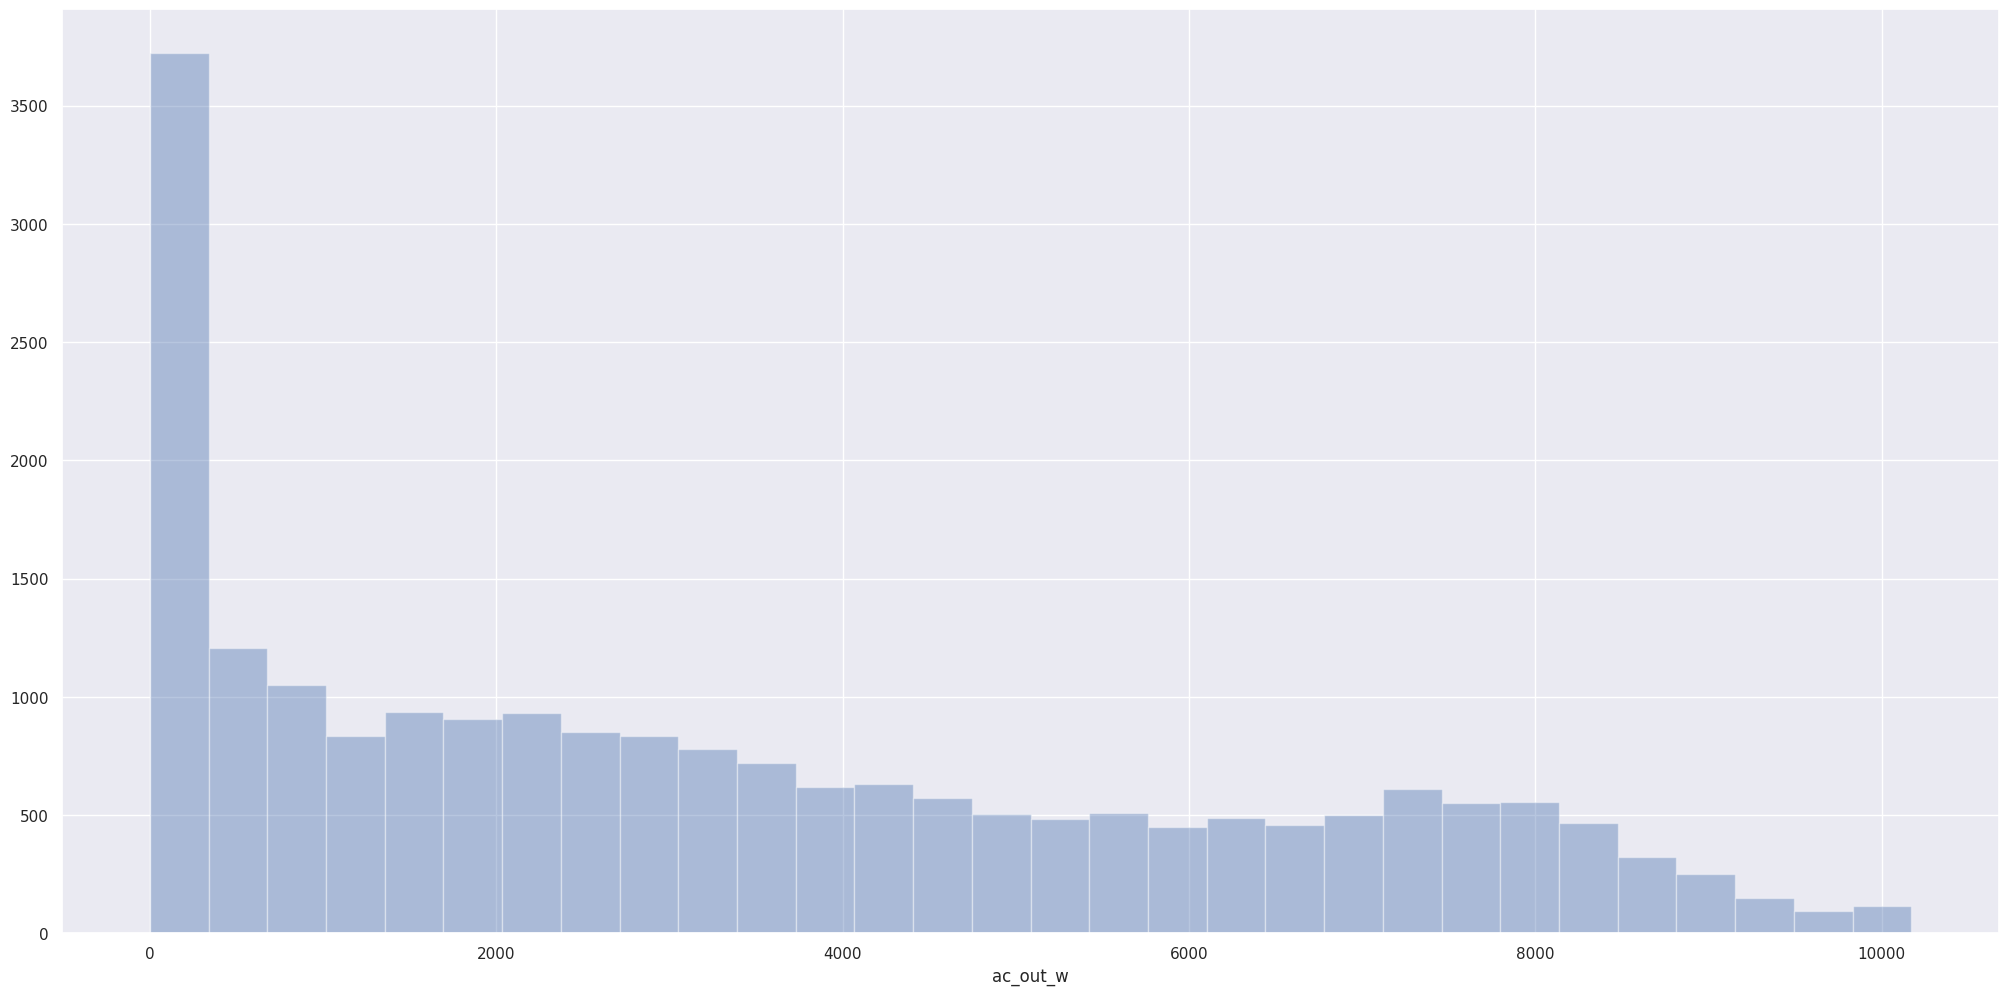

In [ ]:
sns.distplot(df_42['ac_out_w'], kde=False);

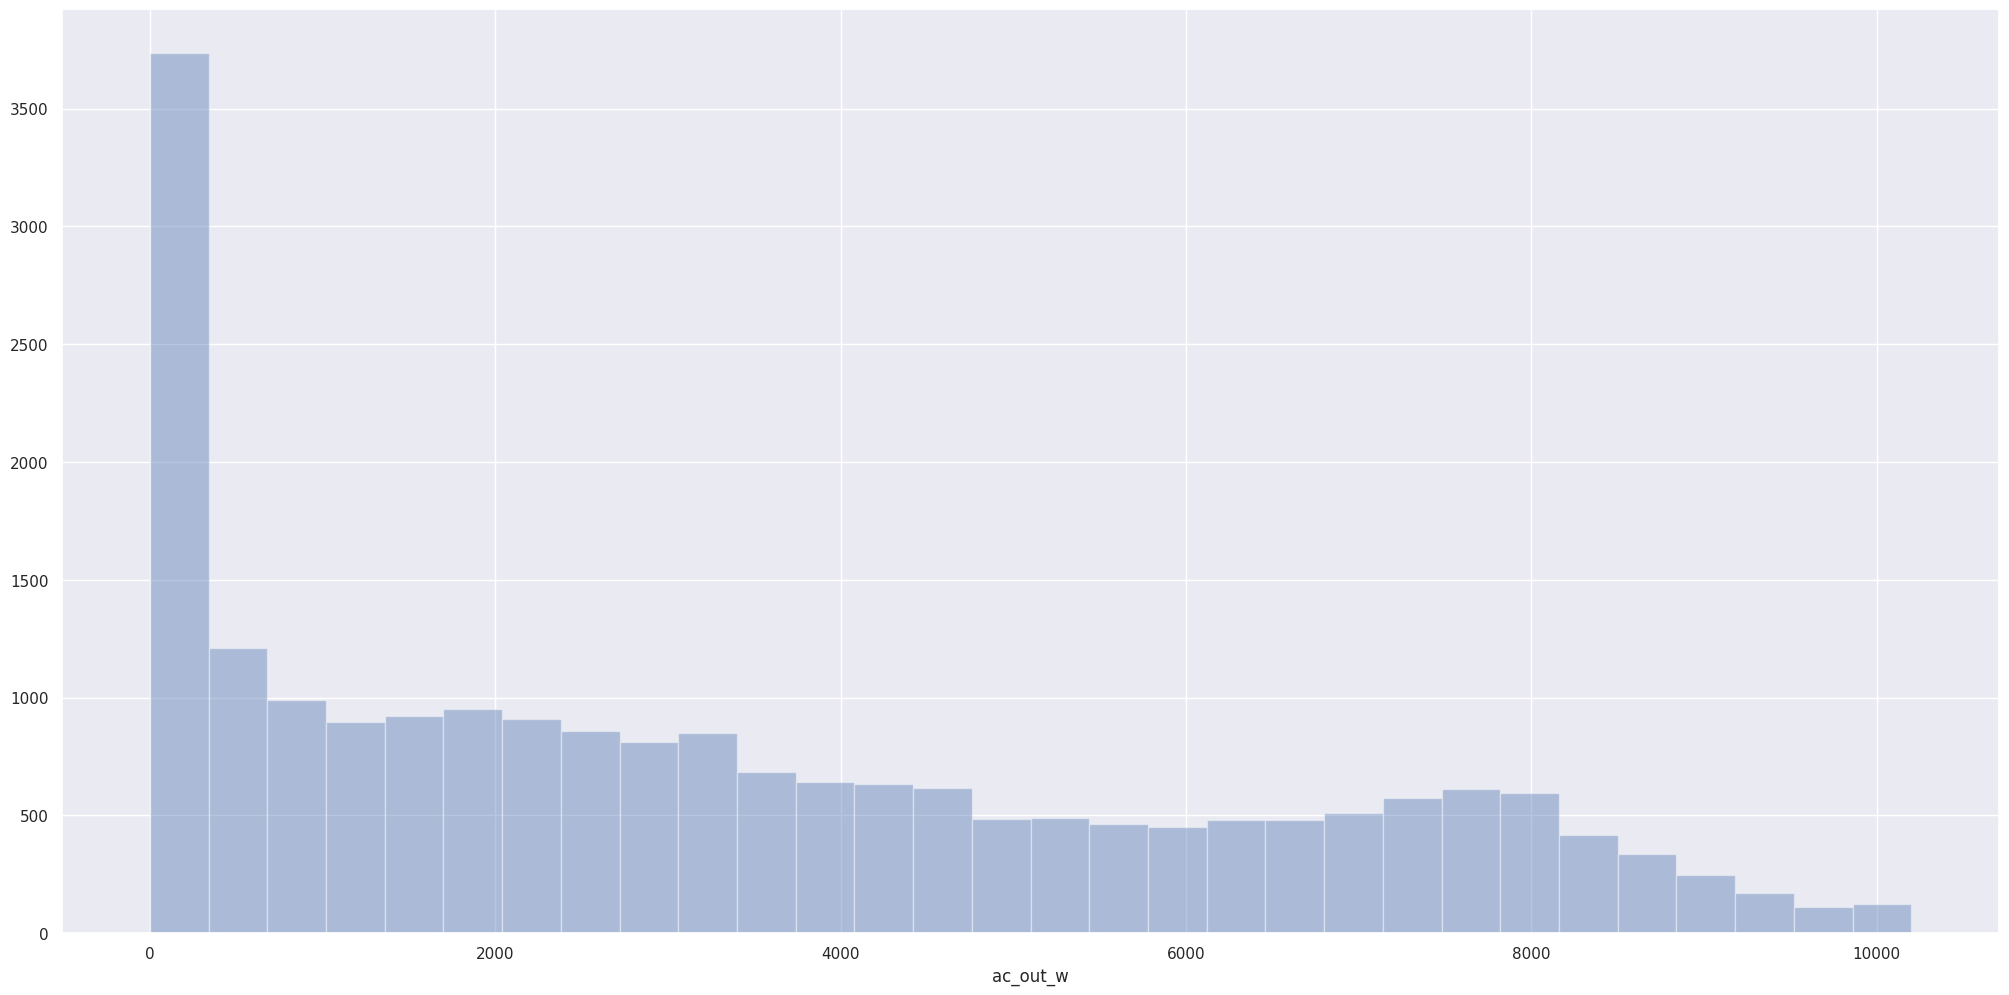

In [ ]:
sns.distplot(df_44['ac_out_w'], kde=False);

### 4.1.2 Numerical Variable

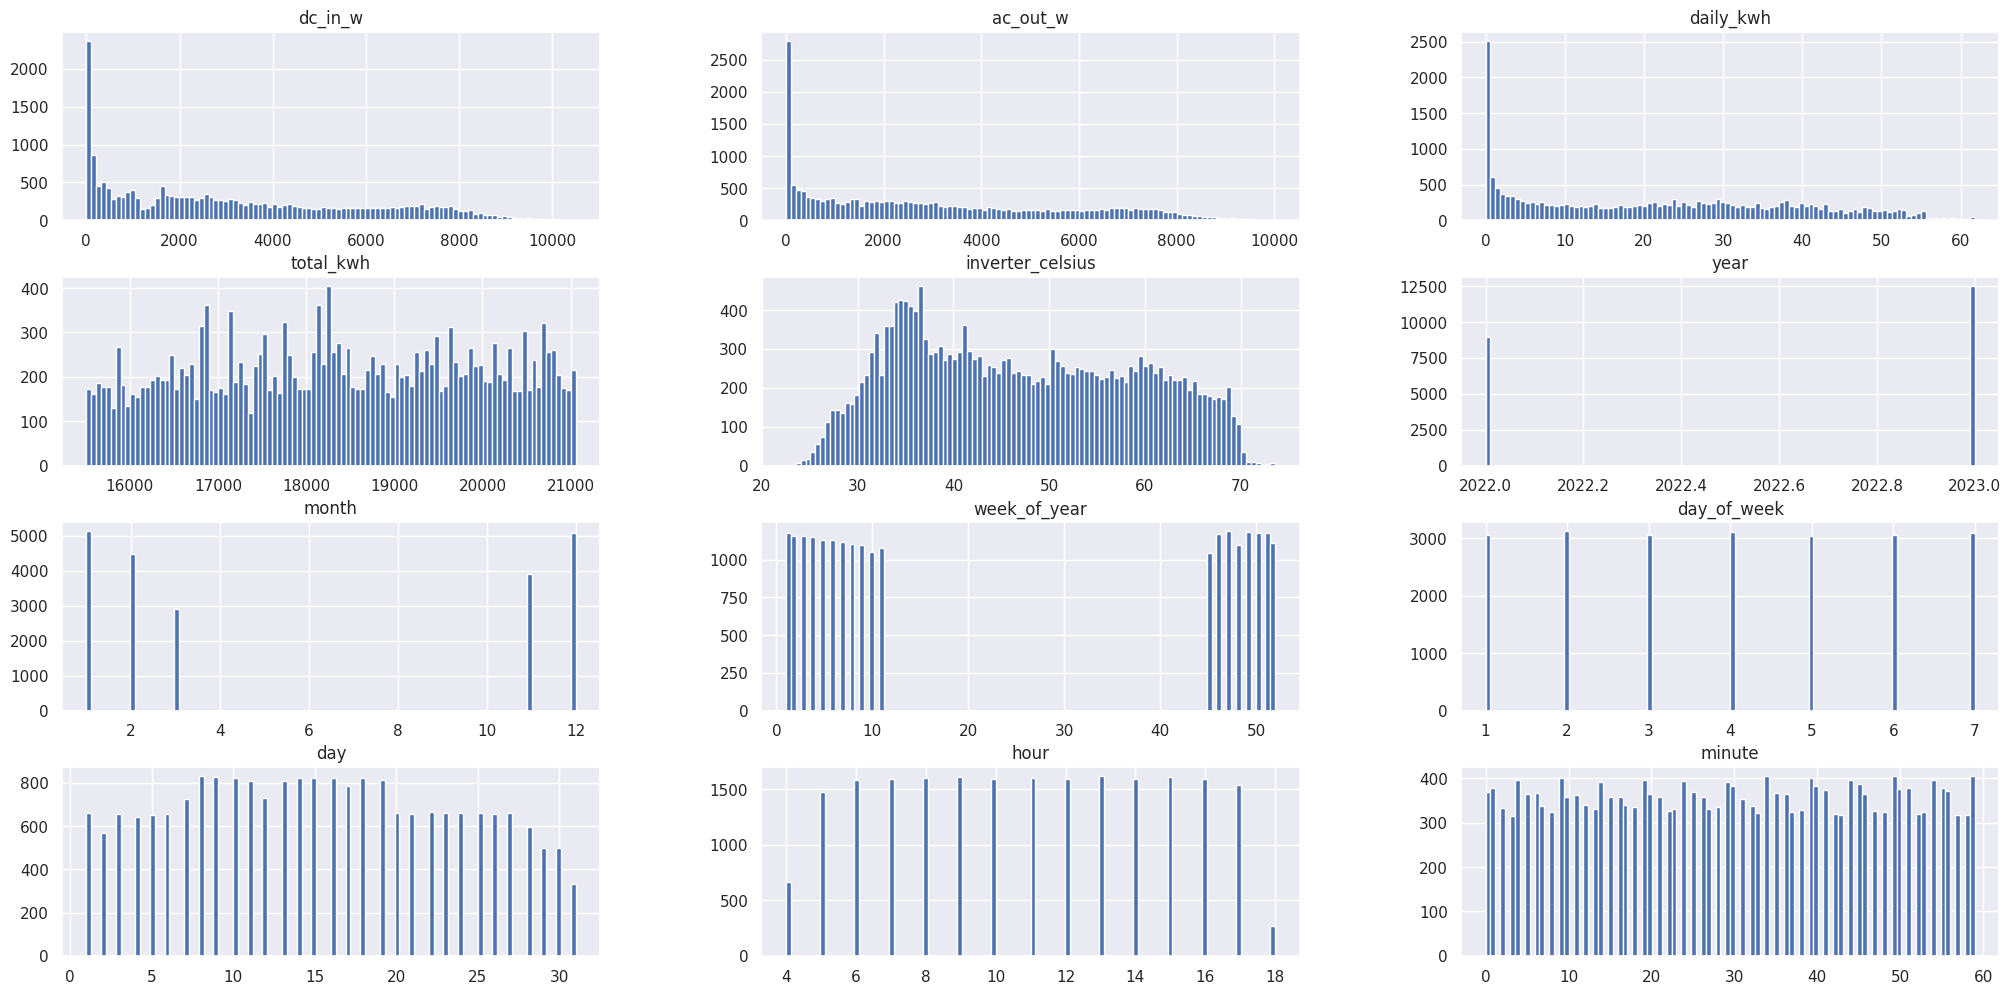

In [ ]:
num_attributes = df_41.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

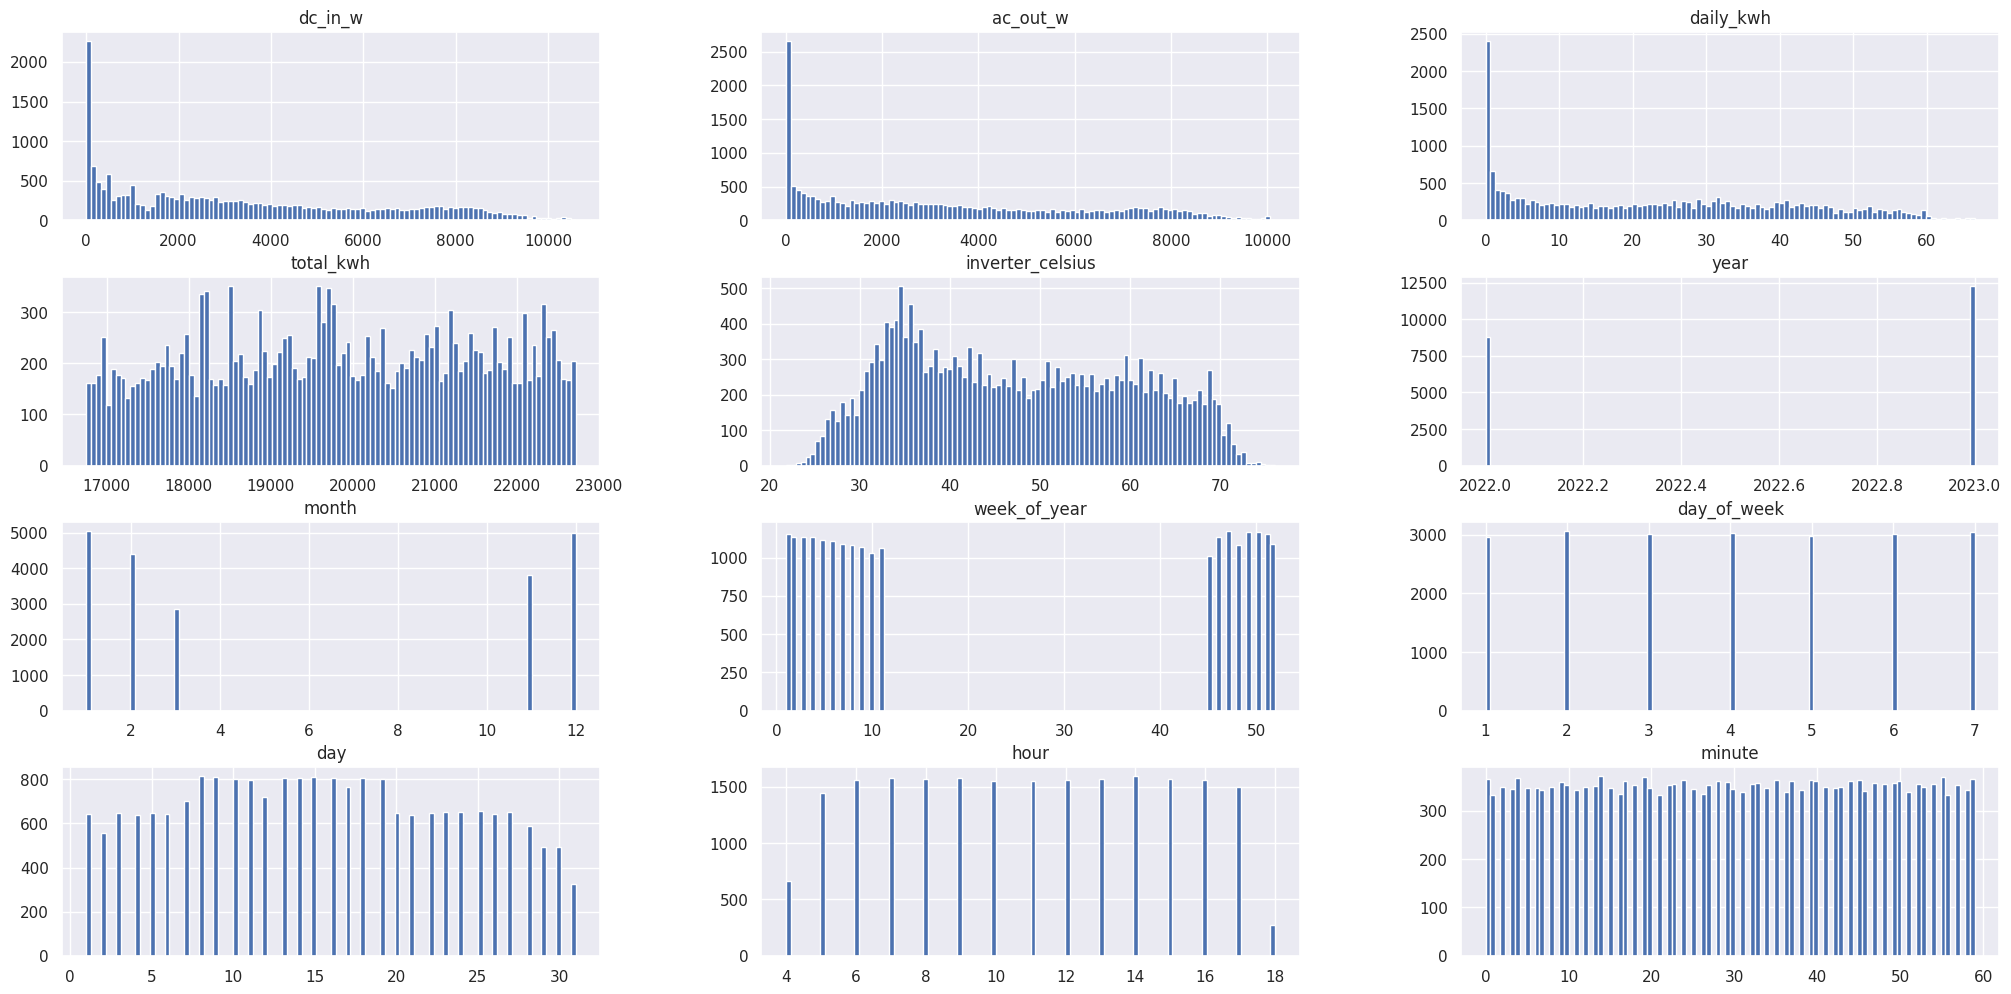

In [ ]:
num_attributes = df_42.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

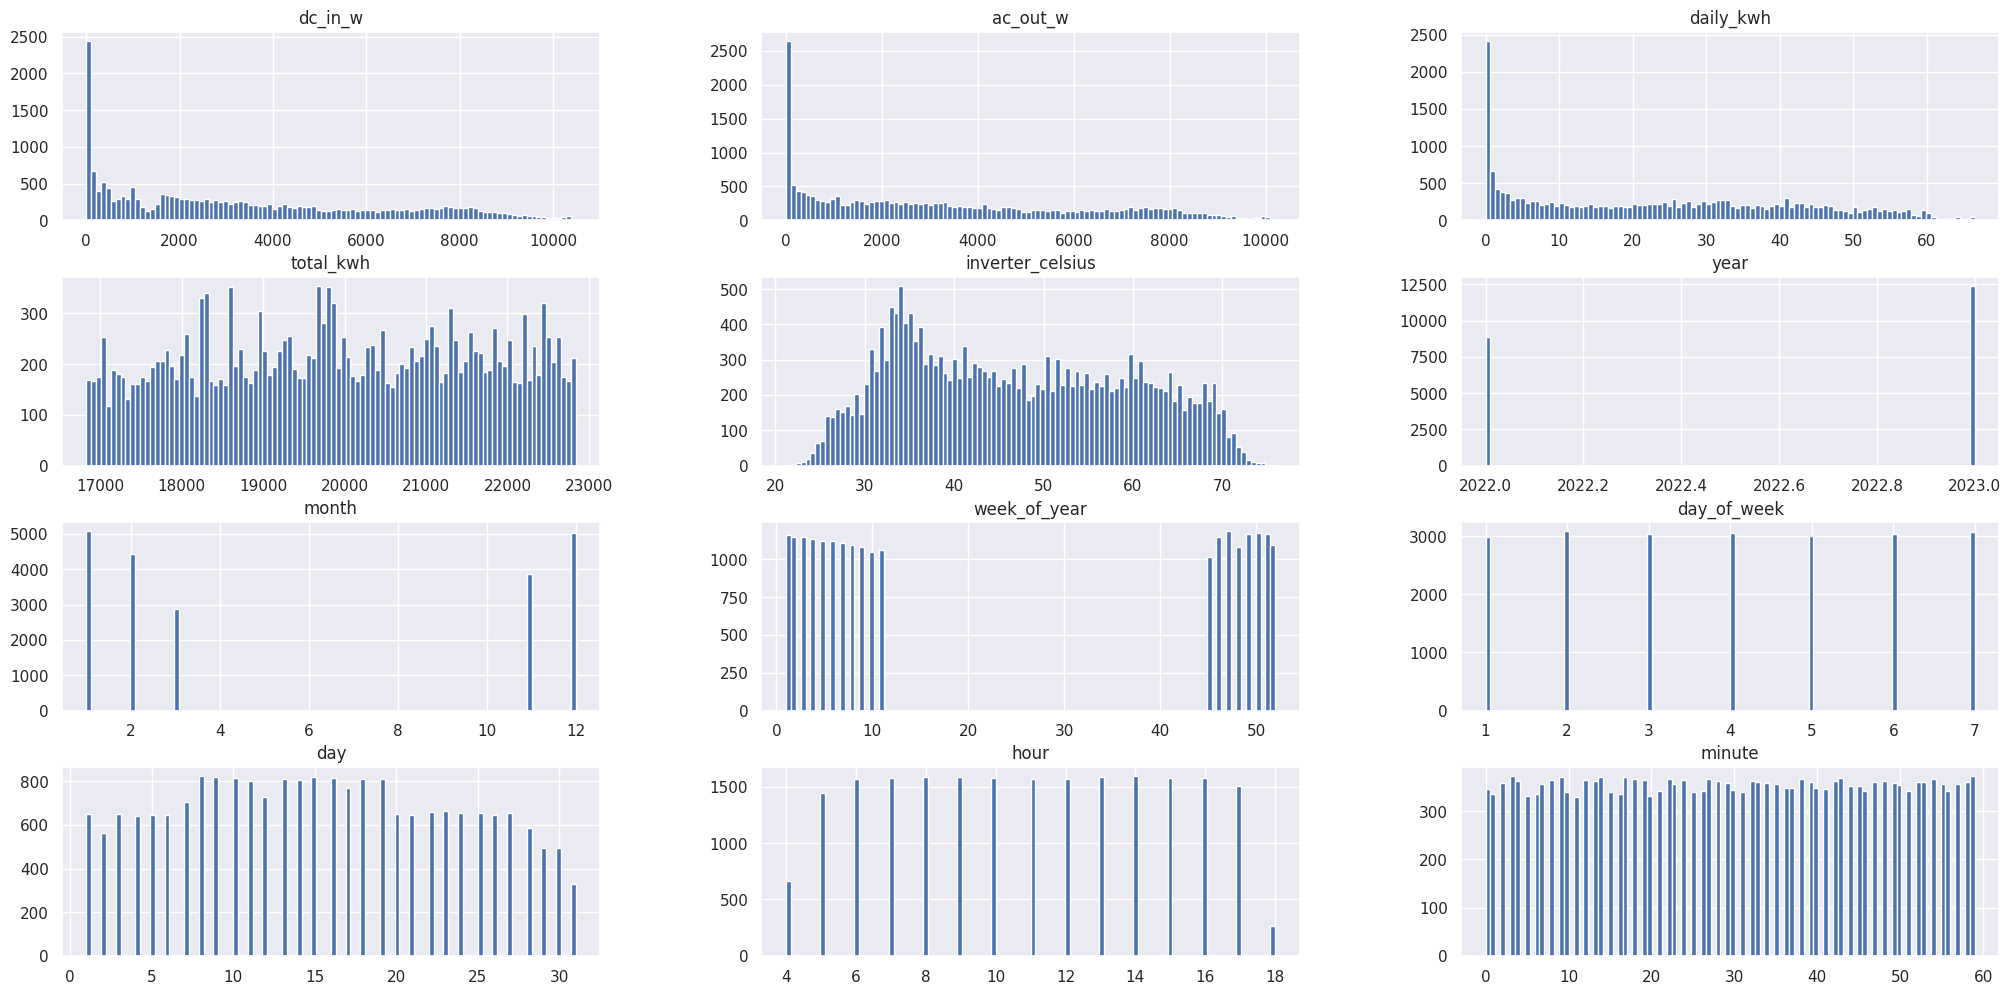

In [ ]:
num_attributes = df_44.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

# 5.0 DATA PREPARATION

## 5.1 Split dataframe into training and test dataset

In [ ]:
# training dataset
df_41_train = df_41[df_41['time'] < '2023-03-13']
df_42_train = df_42[df_42['time'] < '2023-03-13']
df_44_train = df_44[df_44['time'] < '2023-03-13']

# test dataset
df_41_test = df_41[df_41['time'] >= '2023-03-13 ']
df_42_test = df_42[df_42['time'] >= '2023-03-13 ']
df_44_test = df_44[df_44['time'] >= '2023-03-13 ']

print('Training Min Date: {}'. format(df_41_train['time'].min()))
print('Training Max Date: {}'. format(df_41_train['time'].max()))

print('\nTest Date Min Date: {}'. format(df_41_test['time'].min()))
print('Test Max Date: {}'. format(df_41_test['time'].max()))

Training Min Date: 2022-11-07 11:06:00
Training Max Date: 2023-03-12 16:51:00

Test Date Min Date: 2023-03-13 06:08:00
Test Max Date: 2023-03-19 18:38:00


## 5.2 Standardization

In [ ]:
ss = pp.StandardScaler()

## 5.3 Rescaling

In [ ]:
mms = pp.MinMaxScaler()

In [ ]:
def RescalingMMS(df):
    df['ac_out_w'] = mms.fit_transform(df[['ac_out_w']].values)
    #fig = plt.subplots(figsize = (15,5))
    #sns.histplot(df[['ac_out_w']].values, bins = 70);
    df['dc_in_w'] = mms.fit_transform(df[['dc_in_w']].values)
    df['daily_kwh'] = mms.fit_transform(df[['daily_kwh']].values)
    df['total_kwh'] = mms.fit_transform(df[['total_kwh']].values)
    df['inverter_celsius'] = mms.fit_transform(df[['inverter_celsius']].values)

In [ ]:
RescalingMMS(df_41_train)
RescalingMMS(df_41_test)
RescalingMMS(df_42_train)
RescalingMMS(df_42_test)
RescalingMMS(df_44_train)
RescalingMMS(df_44_test)

## 5.4 Nature Transformation

### 5.4.1 Training

In [ ]:
df_41_train['month_sin'] = df_41_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_41_train['month_cos'] = df_41_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_41_train['week_of_year_sin'] = df_41_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_41_train['week_of_year_cos'] = df_41_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_41_train['day_of_week_sin'] = df_41_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_41_train['day_of_week_cos'] = df_41_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_41_train['day_sin'] = df_41_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_41_train['day_cos'] = df_41_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_41_train['hour_sin'] = df_41_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_41_train['hour_cos'] = df_41_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_41_train['minute_sin'] = df_41_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_41_train['minute_cos'] = df_41_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_41_train = df_41_train.drop(cols_drop, axis = 1)

In [ ]:
df_42_train['month_sin'] = df_42_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_42_train['month_cos'] = df_42_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_42_train['week_of_year_sin'] = df_42_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_42_train['week_of_year_cos'] = df_42_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_42_train['day_of_week_sin'] = df_42_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_42_train['day_of_week_cos'] = df_42_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_42_train['day_sin'] = df_42_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_42_train['day_cos'] = df_42_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_42_train['hour_sin'] = df_42_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_42_train['hour_cos'] = df_42_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_42_train['minute_sin'] = df_42_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_42_train['minute_cos'] = df_42_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_42_train = df_42_train.drop(cols_drop, axis = 1)

In [ ]:
df_44_train['month_sin'] = df_44_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_44_train['month_cos'] = df_44_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_44_train['week_of_year_sin'] = df_44_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_44_train['week_of_year_cos'] = df_44_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_44_train['day_of_week_sin'] = df_44_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_44_train['day_of_week_cos'] = df_44_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_44_train['day_sin'] = df_44_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_44_train['day_cos'] = df_44_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_44_train['hour_sin'] = df_44_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_44_train['hour_cos'] = df_44_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_44_train['minute_sin'] = df_44_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_44_train['minute_cos'] = df_44_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_44_train = df_44_train.drop(cols_drop, axis = 1)

### 5.4.2 Test

In [ ]:
df_41_test['month_sin'] = df_41_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_41_test['month_cos'] = df_41_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_41_test['week_of_year_sin'] = df_41_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_41_test['week_of_year_cos'] = df_41_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_41_test['day_of_week_sin'] = df_41_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_41_test['day_of_week_cos'] = df_41_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_41_test['day_sin'] = df_41_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_41_test['day_cos'] = df_41_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_41_test['hour_sin'] = df_41_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_41_test['hour_cos'] = df_41_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_41_test['minute_sin'] = df_41_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_41_test['minute_cos'] = df_41_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_41_test = df_41_test.drop(cols_drop, axis = 1)

In [ ]:
df_42_test['month_sin'] = df_42_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_42_test['month_cos'] = df_42_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_42_test['week_of_year_sin'] = df_42_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_42_test['week_of_year_cos'] = df_42_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_42_test['day_of_week_sin'] = df_42_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_42_test['day_of_week_cos'] = df_42_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_42_test['day_sin'] = df_42_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_42_test['day_cos'] = df_42_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_42_test['hour_sin'] = df_42_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_42_test['hour_cos'] = df_42_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_42_test['minute_sin'] = df_42_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_42_test['minute_cos'] = df_42_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_42_test = df_42_test.drop(cols_drop, axis = 1)

In [ ]:
df_44_test['month_sin'] = df_44_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_44_test['month_cos'] = df_44_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_44_test['week_of_year_sin'] = df_44_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_44_test['week_of_year_cos'] = df_44_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_44_test['day_of_week_sin'] = df_44_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_44_test['day_of_week_cos'] = df_44_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_44_test['day_sin'] = df_44_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_44_test['day_cos'] = df_44_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_44_test['hour_sin'] = df_44_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_44_test['hour_cos'] = df_44_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_44_test['minute_sin'] = df_44_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_44_test['minute_cos'] = df_44_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_44_test = df_44_test.drop(cols_drop, axis = 1)

# 6.0 FEATURE SELECTION

## 6.1 Feature Selection df41

### 6.1.1 Target variable

In [ ]:
# training dataset
y_train_41 = df_41_train['ac_out_w']

# test dataset
y_test_41 = df_41_test['ac_out_w']

### 6.1.2 Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
X_train_n_41 = df_41_train.drop(['id', 'time', 'ac_out_w', 'dc_in_w', 'daily_kwh', 'total_kwh', 'inverter_celsius'], axis = 1).values
y_train_n_41 = y_train_41.values.ravel() # ravel is to vetorize the values

In [ ]:
# define randomforestregressor
rf = RandomForestRegressor(n_jobs = -1)

In [ ]:
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n_41, y_train_n_41)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	5


### 6.2.1 Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs_41 = df_41_train.drop(['id', 'time', 'ac_out_w', 'dc_in_w', 'daily_kwh', 'total_kwh', 'inverter_celsius'], axis = 1) 

In [ ]:
cols_selected_boruta = X_train_fs_41.iloc[:, cols_selected].columns.to_list()

In [ ]:
cols_selected_boruta

['week_of_year_sin',
 'day_of_week_sin',
 'day_sin',
 'day_cos',
 'hour_sin',
 'hour_cos',
 'minute_sin',
 'minute_cos']

# 7.0 MACHINE LEARNING MODELING

In [ ]:
# initially without date and sales
x_train_41 = df_41_train[cols_selected_boruta]
x_test_41  = df_41_test[cols_selected_boruta]

x_train_42 = df_42_train[cols_selected_boruta]
x_test_42  = df_42_test[cols_selected_boruta]

## 7.1 Random Forest Regressor 41

In [ ]:
rf_41 = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train_41, y_train_41)

In [ ]:
# prediction
yhat_rf_41 = rf_41.predict(x_test_41)

In [ ]:
# performance
rf_result_41 = ml_error('Random forest Regressor', np.expm1(y_test_41), np.expm1(yhat_rf_41))
rf_result_41

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,0.280662,2.158343e+13,0.382464


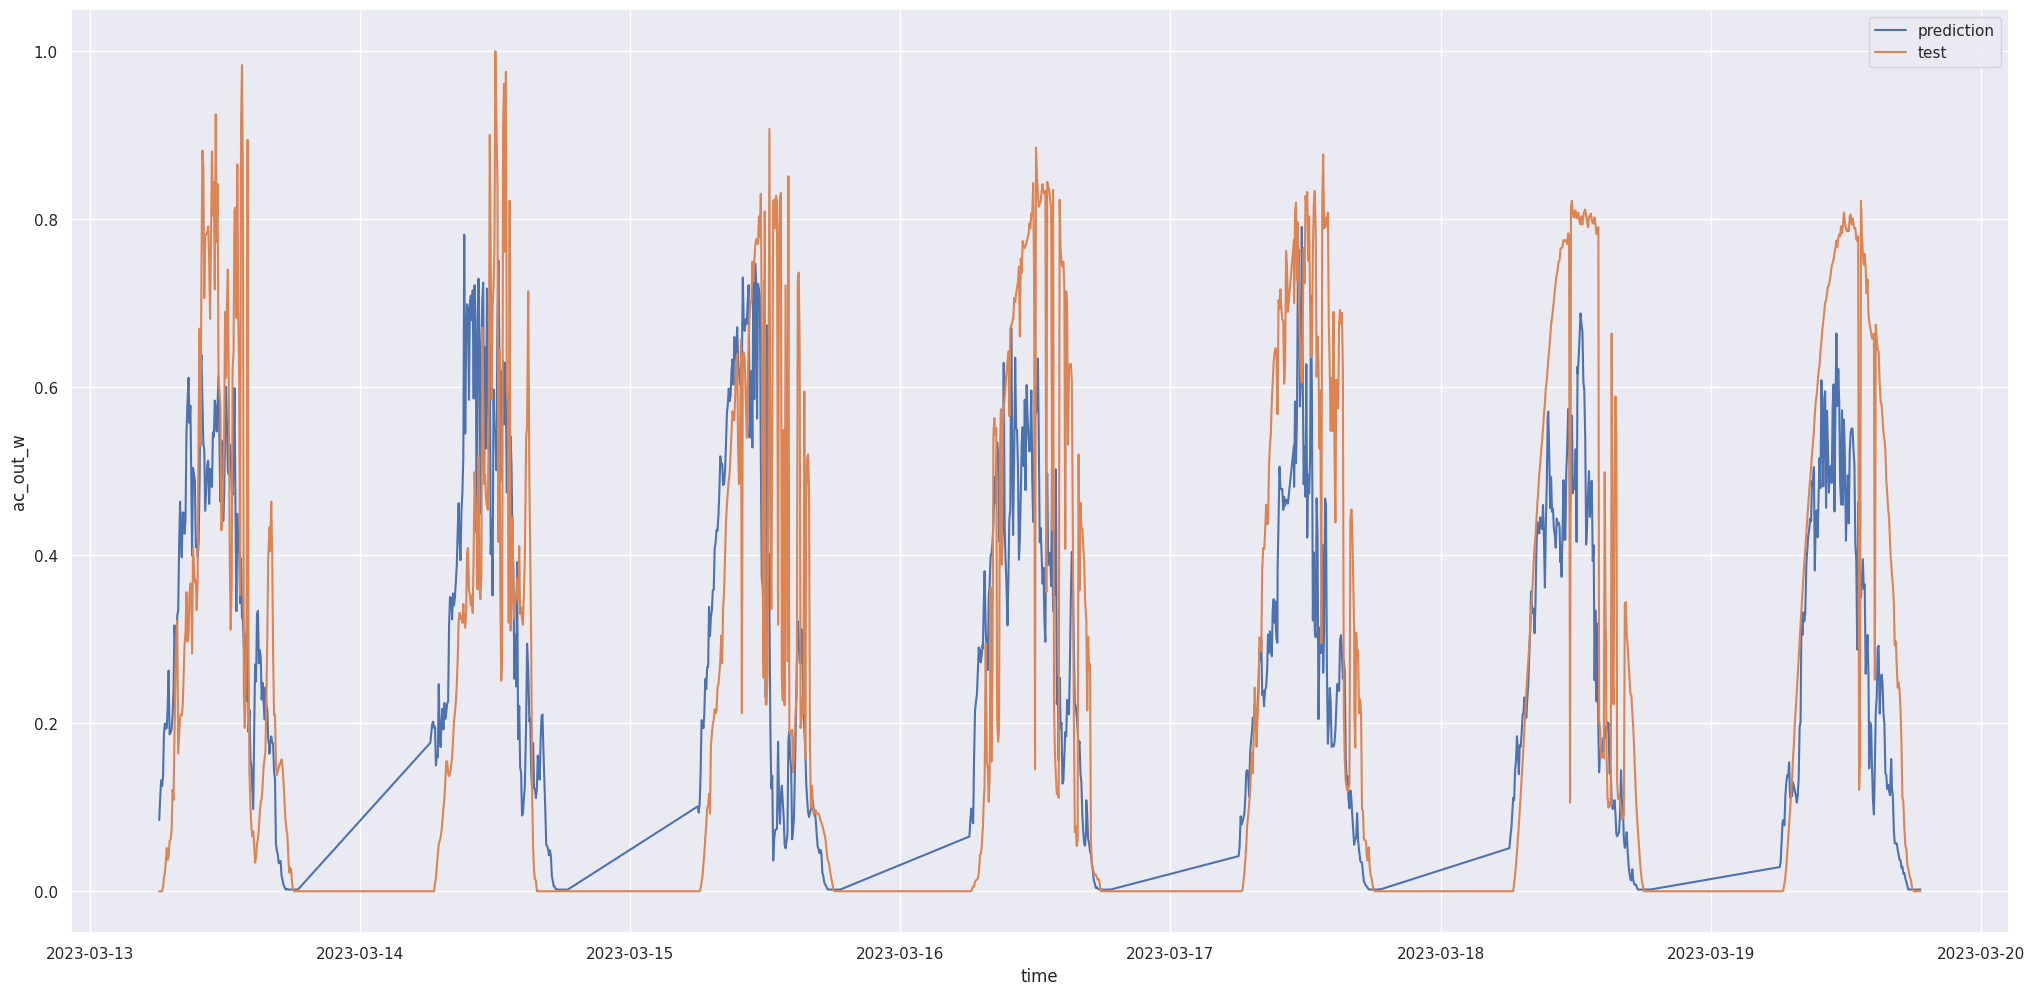

In [ ]:
sns.lineplot(x = df_41_test['time'], y = yhat_rf_41, label = 'prediction')
sns.lineplot(x = df_41_test['time'], y = y_test_41, label = 'test');

## 7.2 Random Forest Regressor 42

In [ ]:
rf_42 = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train_41, y_train_41)

In [ ]:
# prediction
yhat_rf_42 = rf_42.predict(x_test_42)

In [ ]:
# performance
y_test_42 = df_42_test['ac_out_w']

rf_result_42 = ml_error('Random forest Regressor', np.expm1(y_test_42), np.expm1(yhat_rf_42))
rf_result_42

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,0.2476,8.472880e+09,0.336391


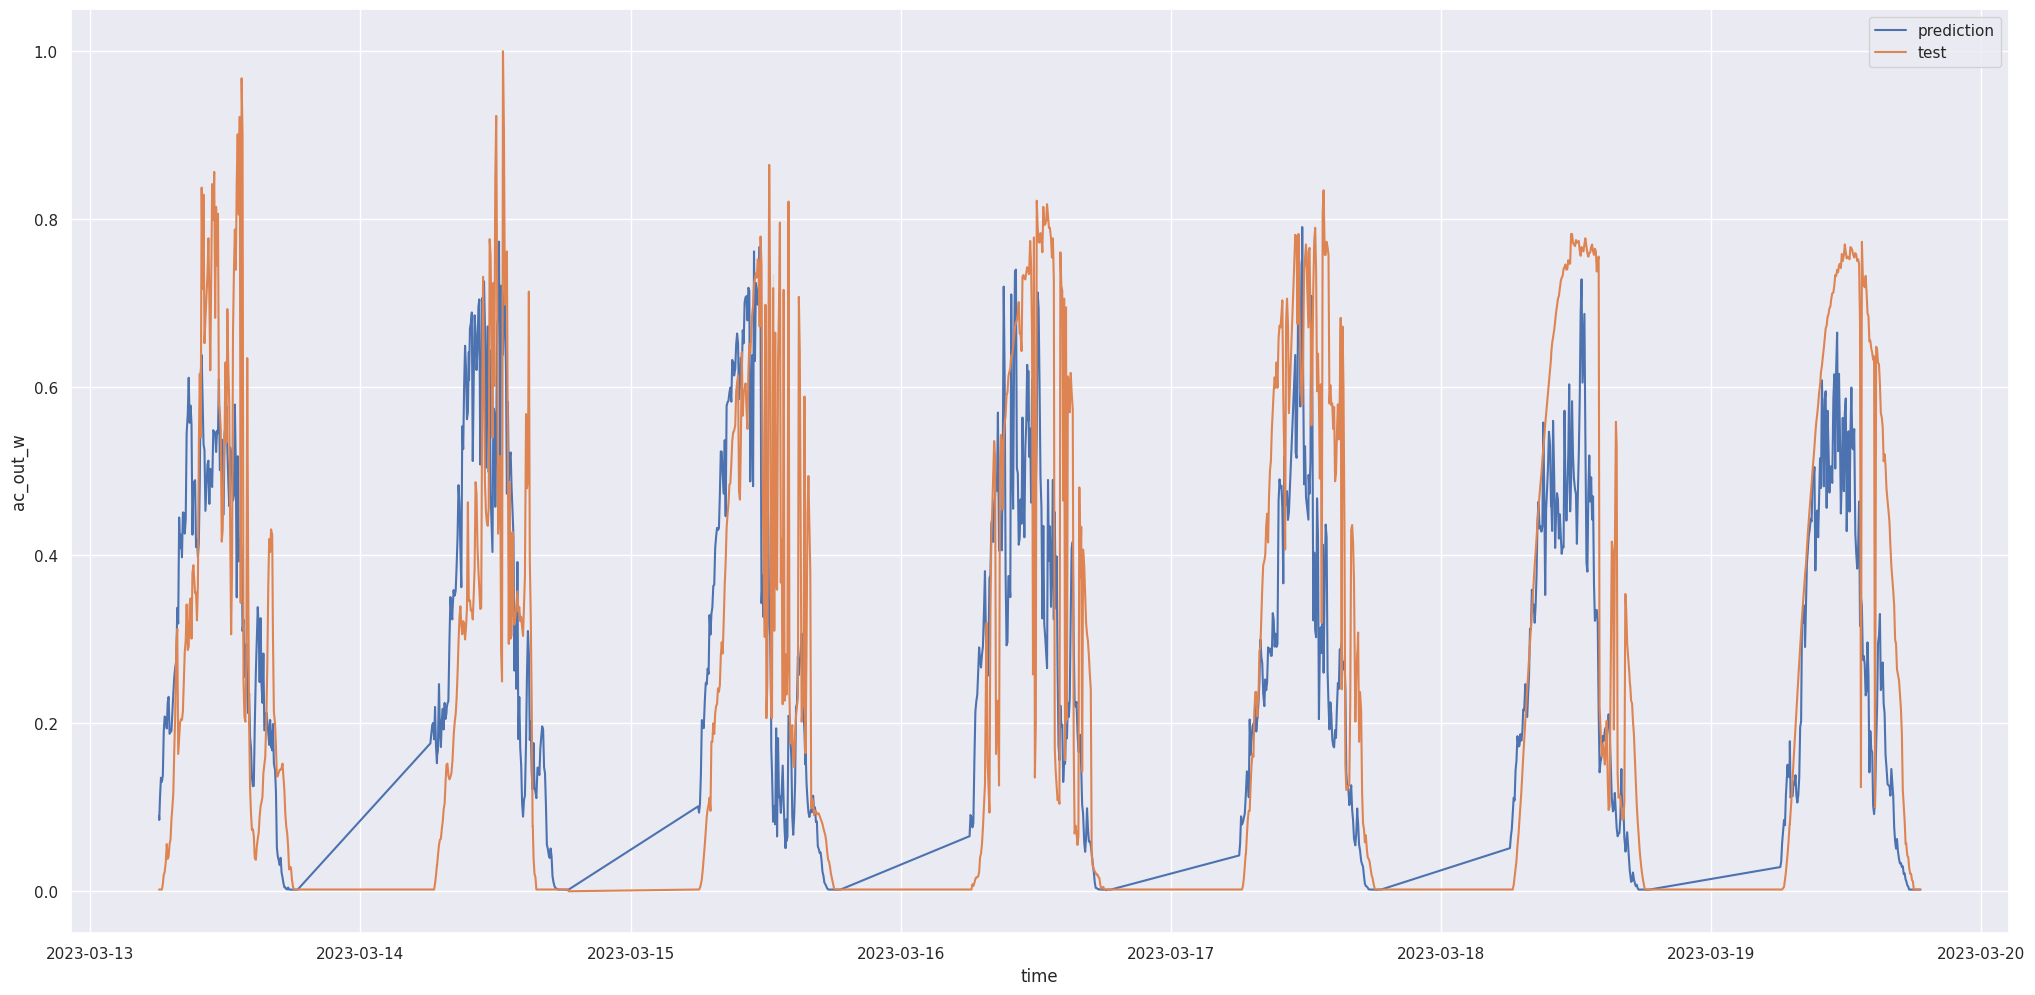

In [ ]:
sns.lineplot(x = df_42_test['time'], y = yhat_rf_42, label = 'prediction')
sns.lineplot(x = df_42_test['time'], y = y_test_42, label = 'test');